In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.decomposition import FactorAnalysis
from fuzzywuzzy import fuzz, process

In [2]:
# Should the R and Python promis_anx and ident values be compared?
compare = False

# Read in processed data.
df = pd.read_csv('summary_spring2020 (30 sec ML no conf in OAT scores).csv', index_col = 'ident') # confidence ratings not used to compute OAT scores
#df = pd.read_csv('summary_spring2020 (30 sec ML).csv', index_col = 'ident') # confidence ratings used to compute OAT scores

df = df.assign(resistance = df.threat_benign_os - df.threat_benign_brel)
df = df.assign(threat_benign_ri = df['threat_benign_brel'] + df['threat_benign_trel'])
df_good = df.loc[df.good_perf].copy() # only participants who pass the performance criterion

# Read in data processed by R.
df_r = pd.read_csv('spring 2020 FAST for comparison with Python.csv', index_col = 'ident')
df_rgood = df_r.loc[df_r.good_perf].copy() # only participants who pass the performance criterion

print(df.shape[0])
print(df_good.shape[0])

127
89


plots


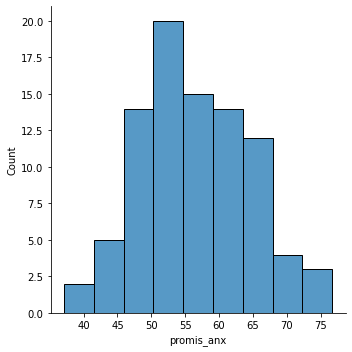

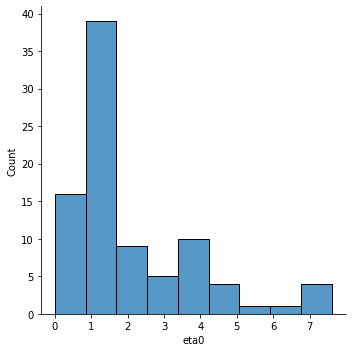

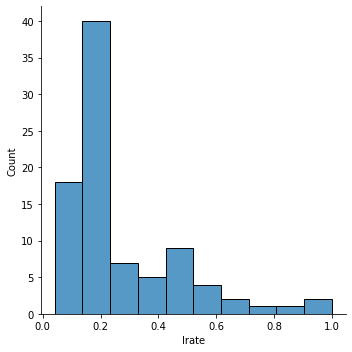

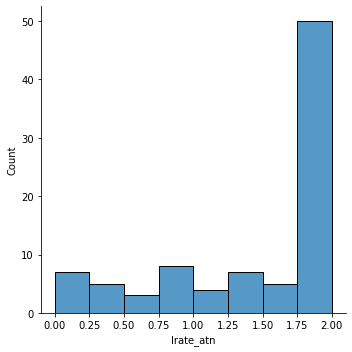

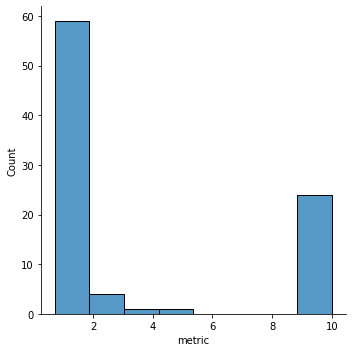

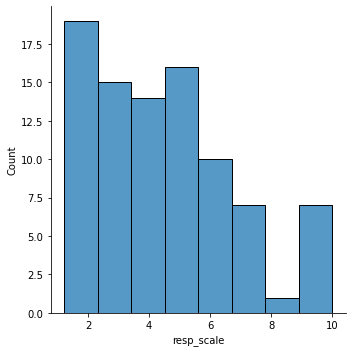

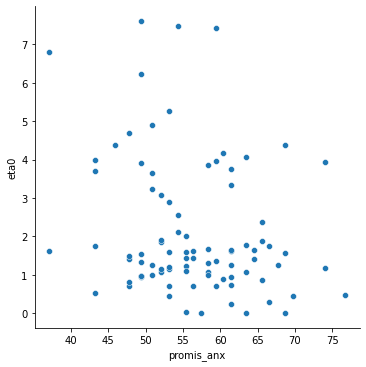

In [4]:
print('plots')
data = df_good
sns.displot(data['promis_anx'])
sns.displot(data['eta0'])
sns.displot(data['lrate'])
sns.displot(data['lrate_atn'])
sns.displot(data['metric'])
sns.displot(data['resp_scale'])
sns.relplot(x = 'promis_anx', y = 'eta0', data = data)

In [6]:
data = df_good

ttests = pd.DataFrame(0.0,
                      index = ['threat_benign_os', 'resistance', 'rel_irl', 'eta0'],
                      columns = ['t', 'p', 'effect_size', 'mean', 'std'])
n = data.shape[0]
for var_name in ttests.index.values:
    if var_name == 'eta0':
        popmean = 1
    else:
        popmean = 0
    result = stats.ttest_1samp(data[var_name], popmean)
    ttests.loc[var_name]['t'] = np.round(result.statistic, 3)
    ttests.loc[var_name]['p'] = np.round(result.pvalue, 3)
    ttests.loc[var_name]['effect_size'] = np.round(result.statistic/np.sqrt(n), 3)
    ttests.loc[var_name]['mean'] = np.round(data[var_name].mean(), 3)
    ttests.loc[var_name]['std'] = np.round(data[var_name].std(), 3)

print('t tests for OAT scores and salience parameter (eta0):')
print('n = ' + str(n))
print(ttests)

t tests for OAT scores and salience parameter (eta0):
n = 89
                       t      p  effect_size   mean    std
threat_benign_os   2.423  0.017        0.257  0.180  0.700
resistance         8.413  0.000        0.892  0.775  0.869
rel_irl           12.257  0.000        1.299  0.629  0.484
eta0               5.905  0.000        0.626  2.106  1.766


In [7]:
print('CORRELATIONS WITH PROMIS ANXIETY \n')
print('n = ' + str(n))
data = df_good

rtests = pd.DataFrame(0.0,
                      index = ['threat_benign_os', 'resistance', 'rel_irl', 'eta0'],
                      columns = ['r', 'p'])
n = data.shape[0]
for var_name in rtests.index.values:
    (r, p) = stats.pearsonr(data['promis_anx'], data[var_name])
    rtests.loc[var_name]['r'] = np.round(r, 2)
    rtests.loc[var_name]['p'] = np.round(p, 4)
print(rtests)

CORRELATIONS WITH PROMIS ANXIETY 

n = 89
                     r       p
threat_benign_os -0.08  0.4547
resistance        0.15  0.1573
rel_irl           0.18  0.0983
eta0             -0.22  0.0349


In [3]:
if compare:
    print('COMPARE PYTHON AND R DATA PROCESSING \n')

    for ident in df_r.index:
        best_match, match_pct = process.extractOne(ident, df.index, scorer = fuzz.ratio)
        print(ident)
        print(best_match)
        print(df_r.loc[ident, 'promis_anx_sum'])
        print(df.loc[best_match, 'promis_anx_sum'])
        if not ident in df.index:
            print('Ach nein!!! \n')
        else:
            print()

# This reveals that - even when the Python and R scripts agree on the ID - they sometimes calculate different values
# of promis_anx_sum.  Spot checking the original spreadsheet (used by the Python code) shows that the R code is correct.
# The Python code is in fact adding up the numbers that have been imported into Python correctly.
# This means that - for some reason - the numbers are not being imported into Python correctly.
# PROBLEM SOLVED: I changed the Python data import code to loop through FAST IDs rather than through survey IDs
# when doing ID matching.

In [20]:
print('COMPARE R AND PYTHON MODEL FITS (T TESTS) \n')

ttests = pd.DataFrame(0.0,
                      index = ['prop_log_post', 'eta0', 'lrate', 'lrate_atn', 'metric', 'resp_scale'],
                      columns = ['t', 'p', 'mean_inlab', 'mean_online'])
for var_name in ttests.index.values:
    result = stats.ttest_1samp(df_r[var_name], df[var_name])
    ttests.loc[var_name]['t'] = np.round(result.statistic, 3)
    ttests.loc[var_name]['p'] = np.round(result.pvalue, 3)
    ttests.loc[var_name]['mean_online'] = np.round(df_r[var_name].mean(), 3)
    ttests.loc[var_name]['mean_inlab'] = np.round(df[var_name].mean(), 3)
print(ttests)

COMPARE R AND PYTHON MODEL FITS (T TESTS) 



ValueError: No axis named 1 for object type Series

In [15]:
print('COMPARE R AND PYTHON MODEL FITS (CORRELATIONS) \n')
print('For some reason, the indices are not lining up correctly, so these correlations are incorrect.')
print('Scatter plots show that there is a high correlation between R and Python model estimates.')

rtests = pd.DataFrame(0.0,
                      index = ['eta0', 'lrate', 'lrate_atn', 'metric', 'resp_scale'],
                      columns = ['r', 'p'])
for var_name in rtests.index.values:
    (r, p) = stats.pearsonr(df_r[var_name], df[var_name])
    rtests.loc[var_name]['r'] = np.round(r, 3)
    rtests.loc[var_name]['p'] = np.round(p, 3)
print(rtests)

COMPARE R AND PYTHON MODEL FITS (CORRELATIONS) 

                r      p
eta0        0.058  0.521
lrate      -0.049  0.588
lrate_atn   0.013  0.885
metric      0.144  0.105
resp_scale  0.149  0.095


In [11]:
print('CORRELATIONS (PYTHON FIT) \n')
print('Note that we are using the full PROMIS scores instead of raw sums.')
data = df_good
x = ['eta0'] + 3*['promis_anx'] + 2*['promis_ang'] + 2*['promis_anx']
y = ['threat_benign_os', 'threat_benign_ri'] + 2*['threat_benign_os', 'eta0'] + ['promis_ang', 'promis_pos']
n_rows = len(x)
rtests = pd.DataFrame(index = range(n_rows),
                      columns = ['x', 'y', 'r', 'p', 'n'])
for i in range(n_rows):
    data_ok = data[[x[i], y[i]]].dropna()
    x_var = data_ok[x[i]]
    y_var = data_ok[y[i]]
    rtests.iloc[i]['x'] = x[i]
    rtests.iloc[i]['y'] = y[i]
    (r, p) = stats.pearsonr(x_var, y_var)
    rtests.iloc[i]['r'] = np.round(r, 2)
    rtests.iloc[i]['p'] = np.round(p, 4)
    rtests.iloc[i]['n'] = data_ok.shape[0]
print(rtests)

CORRELATIONS (PYTHON FIT) 

Note that we are using the full PROMIS scores instead of raw sums.
            x                 y     r       p   n
0        eta0  threat_benign_os  0.24  0.0208  89
1  promis_anx  threat_benign_ri -0.28  0.0087  89
2  promis_anx  threat_benign_os -0.08  0.4547  89
3  promis_anx              eta0 -0.22  0.0349  89
4  promis_ang  threat_benign_os  -0.1  0.3491  89
5  promis_ang              eta0 -0.04  0.7341  89
6  promis_anx        promis_ang  0.63       0  89
7  promis_anx        promis_pos -0.46       0  89


In [9]:
print('CORRELATIONS (R FIT) \n')
data = df_rgood
x = ['eta0'] + 3*['promis_anx_sum'] + 2*['promis_ang_sum'] + 2*['promis_anx_sum']
y = ['threat_benign_os', 'threat_benign_ri'] + 2*['threat_benign_os', 'eta0'] + ['promis_ang_sum', 'promis_pos_sum']
n_rows = len(x)
rtests = pd.DataFrame(index = range(n_rows),
                      columns = ['x', 'y', 'r', 'p', 'n'])
for i in range(n_rows):
    data_ok = data[[x[i], y[i]]].dropna()
    x_var = data_ok[x[i]]
    y_var = data_ok[y[i]]
    rtests.iloc[i]['x'] = x[i]
    rtests.iloc[i]['y'] = y[i]
    (r, p) = stats.pearsonr(x_var, y_var)
    rtests.iloc[i]['r'] = np.round(r, 2)
    rtests.iloc[i]['p'] = np.round(p, 4)
    rtests.iloc[i]['n'] = data_ok.shape[0]
print(rtests)

CORRELATIONS (R FIT) 

                x                 y     r       p   n
0            eta0  threat_benign_os  0.28  0.0076  89
1  promis_anx_sum  threat_benign_ri -0.25  0.0178  89
2  promis_anx_sum  threat_benign_os -0.15  0.1737  89
3  promis_anx_sum              eta0 -0.22  0.0371  89
4  promis_ang_sum  threat_benign_os  -0.1  0.3368  89
5  promis_ang_sum              eta0 -0.02  0.8691  89
6  promis_anx_sum    promis_ang_sum  0.64       0  89
7  promis_anx_sum    promis_pos_sum -0.48       0  89


In [19]:
print(df_rgood.index)
print(df_good.index)

Index(['1116nawes', '1014cynis', '0630mypou', '1111jeara', '0716lyeas',
       '1111heche', '0620junot', '1121romou', '1201kearm', '0512chwuh',
       '0522kafhs', '0612cemul', '0822susky', '1030masky', '1121chsts',
       '0319jebis', '1001chcas', '0125kefos', '0602shpas', '0221saabd',
       '0810tatak', '0601samer', '0107naaus', '1101livis', '0625limou',
       '0129cyale', '0118cathu', '0126krchy', '0128meher', '1002casan',
       '0307caseh', '0329doher', '0215irara', '0212baben', '0628elnot',
       '0721cahar', '0224mafai', '0410legra', '0316duher', '0501trbou',
       '1125kilit', '0905iraqu', '0118lifli', '0331jamur', '0829jurus',
       '0818karoc', '1116lotor', '0610crces', '1111jalak', '0303kareg',
       '1001renor', '0917jahal', '0127trcen', '0810kaste', '1118cacat',
       '0804eidis', '1208jucor', '1030hutre', '0319jevai', '0118keche',
       '0816kamon', '0227macou', '1021famul', '1010meche', '0111gariv',
       '0709kabis', '0202amwin', '0426polyn', '0614sunor', '1127

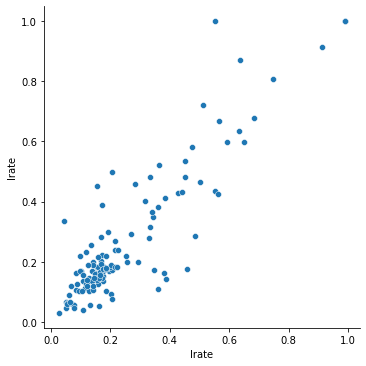

In [6]:
sns.relplot(x = df_r['lrate'], y = df['lrate'])

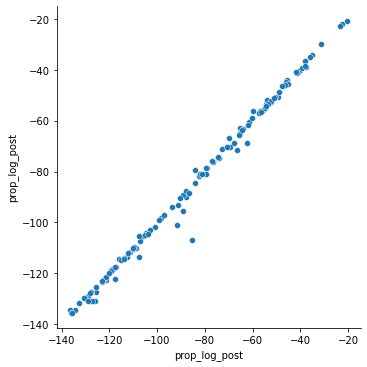

In [5]:
sns.relplot(x = df_r['prop_log_post'], y = df['prop_log_post'])